In [6]:
!pip install -q neurokit2 PyWavelets wfdb matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [30]:
import os
import wfdb
import neurokit2 as nk

data_dir = 'validation'
filenames = [
    os.path.join(data_dir, f.split('.')[0])
    for f in os.listdir(data_dir)
    if f.endswith('.hea')
]
filenames.sort()
records = [wfdb.rdrecord(f) for f in filenames]
conditions = ['NORM', 'AFLT', '1dAVB', 'AFIB', 'RBBB', 'LBBB']

In [32]:
sig_names = record.sig_name
sig_names

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

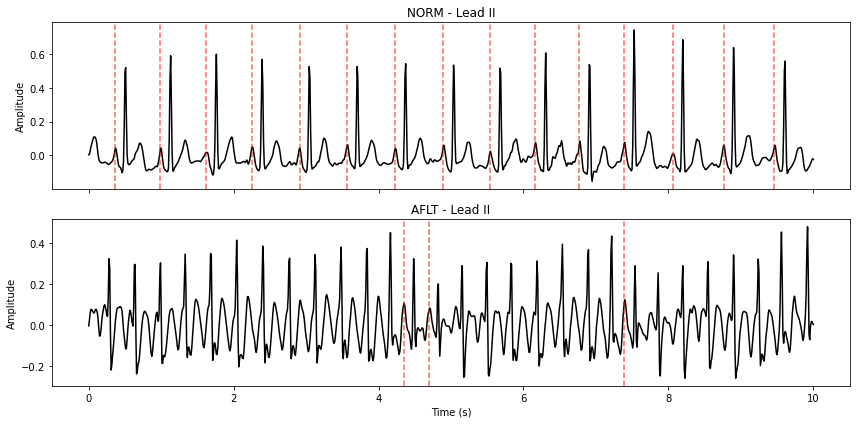

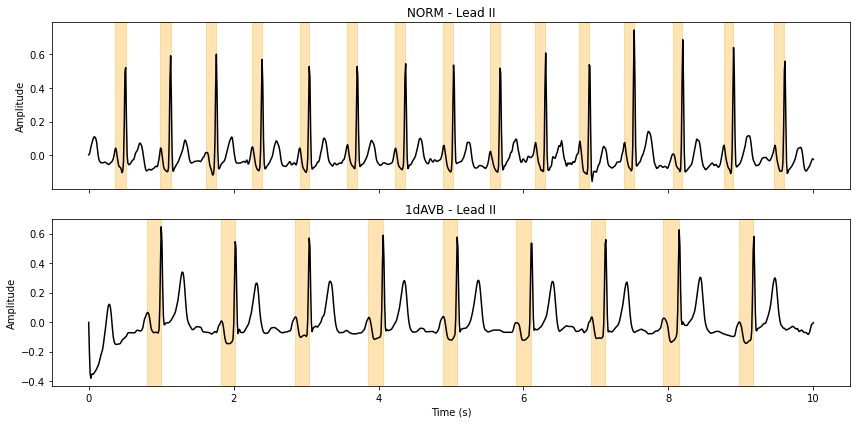

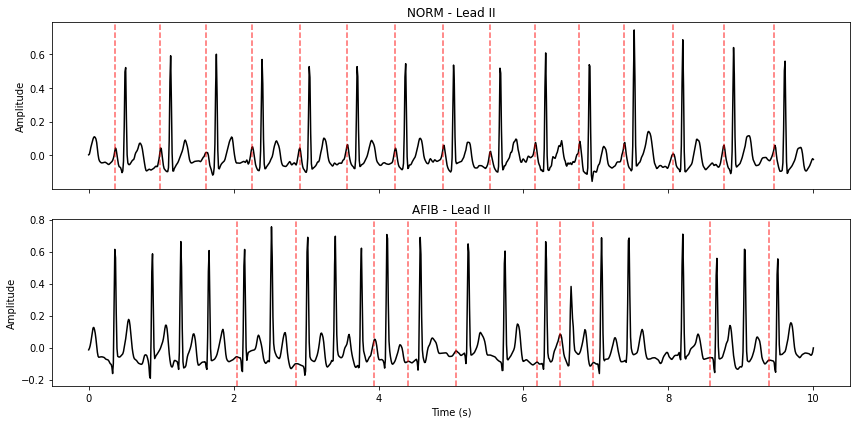

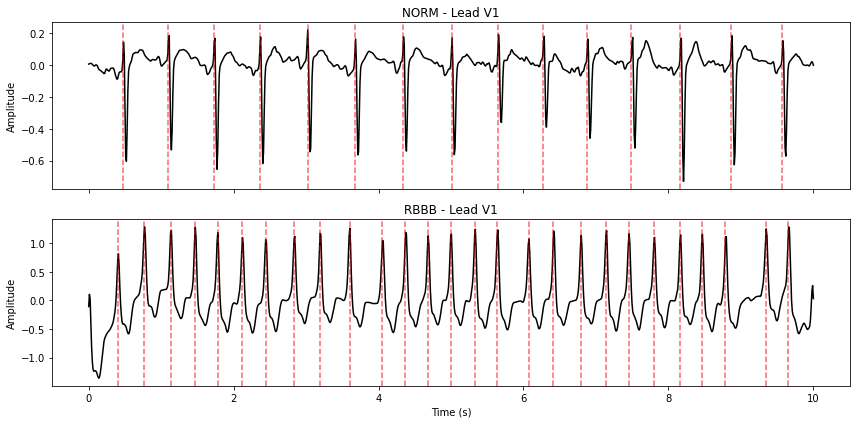

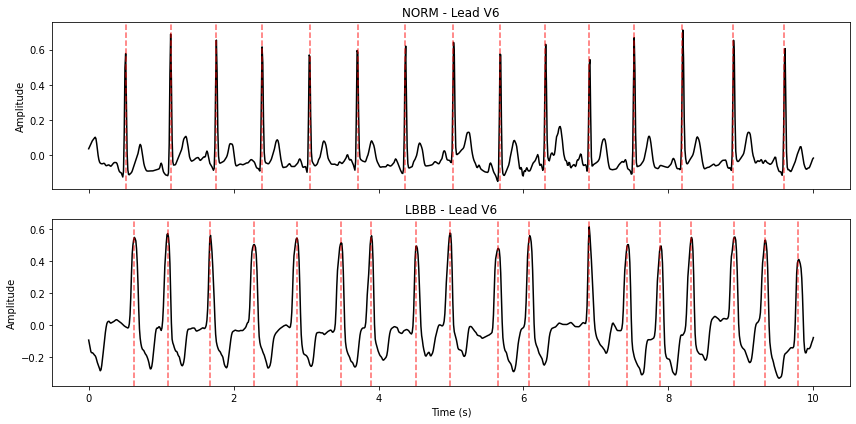

In [34]:
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure output directory exists
os.makedirs("results/figures", exist_ok=True)

# Conditions to compare (excluding NORM from loop, it's always the baseline)
conditions_to_plot = ['AFLT', '1dAVB', 'AFIB', 'RBBB', 'LBBB']
baseline_condition = 'NORM'

# Updated dictionary with lead and wave of interest
condition_to_lead_wave = {
    "NORM": {"lead": "II", "wave": "full"},
    "AFLT": {"lead": "II", "wave": "p_peaks"},
    "1dAVB": {"lead": "II", "wave": "pr_interval"},
    "AFIB": {"lead": "II", "wave": "p_peaks"},
    "RBBB": {"lead": "V1", "wave": "rpeaks"},
    "LBBB": {"lead": "V6", "wave": "rpeaks"}
}

# Load records (assuming same order as conditions)
records = [wfdb.rdrecord(f) for f in filenames]
conditions = ['NORM', 'AFLT', '1dAVB', 'AFIB', 'RBBB', 'LBBB']
condition_to_record = dict(zip(conditions, records))

# Loop over selected conditions
for condition in conditions_to_plot:
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    for i, cond in enumerate([baseline_condition, condition]):
        record = condition_to_record[cond]
        lead_name = condition_to_lead_wave[condition]["lead"]  # use same lead as abnormal
        wave_type = condition_to_lead_wave[condition]["wave"]

        # Extract ECG from target lead
        lead_idx = record.sig_name.index(lead_name)
        ecg = record.p_signal[:, lead_idx]
        fs = record.fs

        # Clean + Process ECG
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=fs)
        ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)

        # Plot first 10 seconds
        samples = int(fs * 10)
        time = np.linspace(0, 10, samples)
        signal = ecg_cleaned[:samples]

        axs[i].plot(time, signal, label=f"{cond} - Lead {lead_name}", color='black')

        if wave_type == "rpeaks":
            peaks = ecg_info["ECG_R_Peaks"]
        elif wave_type == "p_peaks":
            peaks = ecg_info.get("ECG_P_Peaks", [])
        elif wave_type == "pr_interval":
            # Highlight PR interval with shaded region
            p_peaks = ecg_info.get("ECG_P_Peaks", [])
            r_peaks = ecg_info.get("ECG_R_Peaks", [])
            for p, r in zip(p_peaks, r_peaks):
                if p < samples and r < samples:
                    axs[i].axvspan(p / fs, r / fs, color='orange', alpha=0.3, label="PR interval")
            peaks = []
        else:
            peaks = []

        # Add peak markers
        if isinstance(peaks, (list, np.ndarray)):
            for peak in peaks:
                if peak < samples:
                    axs[i].axvline(x=peak / fs, color='red', linestyle='--', alpha=0.6)

        axs[i].set_title(f"{cond} - Lead {lead_name}")
        axs[i].set_ylabel("Amplitude")

    axs[1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.savefig(f"results/figures/{condition}.png", dpi=300)
    plt.show()